In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyLIMA.fits import DE_fit
from pyLIMA.fits import TRF_fit
from pyLIMA.models import PSPL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.models import USBL_model, pyLIMA_fancy_parameters
from pyLIMA.outputs import pyLIMA_plots

from pyLIMA import event
from pyLIMA import telescopes
import pandas as pd

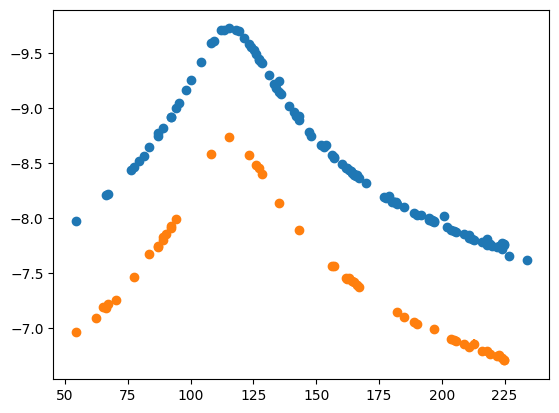

In [2]:
columns = ["HJD-2.449e+06", "r", "err_r", "b", "err_b", "obsid", "tran"]

# Reading the data into a pandas DataFrame
df = pd.read_csv("/home/anibal/Downloads/104.20251.50.publc.txt", delim_whitespace=True, comment='#', names=columns)
df

plt.errorbar(df["HJD-2.449e+06"][df["err_r"]>0],df["r"][df["err_r"]>0],df["err_r"][df["err_r"]>0],marker="o",ls="")

plt.errorbar(df["HJD-2.449e+06"][df["err_b"]>0],df["b"][df["err_b"]>0],df["err_b"][df["err_b"]>0],marker="o",ls="")
plt.gca().invert_yaxis()

In [3]:
t0 = 2.449e+06+125

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# The coordinates in RA (hours, minutes, seconds) and Dec (degrees, arcminutes, arcseconds)
coords = "18:03:34.050 -28:00:18.94"

# Converting to RA and Dec in decimal degrees using SkyCoord
sky_coord = SkyCoord(coords, unit=(u.hourangle, u.deg))

# Get RA and Dec in decimal degrees
ra_dec = (sky_coord.ra.deg, sky_coord.dec.deg)
print(f"RA: {ra_dec[0]} degrees, Dec: {ra_dec[1]} degrees")



RA: 270.89187499999997 degrees, Dec: -28.00526111111111 degrees


In [5]:
# Assuming 'df' is the pandas DataFrame with the column "HJD-2.449e+06"
df['JD'] = df['HJD-2.449e+06'] + 2.449e+06

# Display the updated DataFrame
print(df[['HJD-2.449e+06', 'JD']])


     HJD-2.449e+06            JD
0          54.2919  2.449054e+06
1          62.2839  2.449062e+06
2          65.2374  2.449065e+06
3          66.2445  2.449066e+06
4          67.2132  2.449067e+06
..             ...           ...
110       223.9673  2.449224e+06
111       224.8878  2.449225e+06
112       224.9697  2.449225e+06
113       226.9415  2.449227e+06
114       233.8821  2.449234e+06

[115 rows x 2 columns]


In [6]:
time_r = df["JD"][df["err_r"]>0]
mag_r = df["r"][df["err_r"]>0]
magerr_r = df["err_r"][df["err_r"]>0]
r_array = np.column_stack((time_r, mag_r, magerr_r))

time_b = df["JD"][df["err_b"]>0]
mag_b = df["b"][df["err_b"]>0]
magerr_b = df["err_b"][df["err_b"]>0]
b_array = np.column_stack((time_b, mag_b, magerr_b))

In [7]:

your_event = event.Event(ra=ra_dec[0], dec=ra_dec[1])
your_event.name = '104.20251.50'

telescope_1 = telescopes.Telescope(name = 'r', 
                                   camera_filter = 'r',
                                   light_curve = r_array.astype(float),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

telescope_2 = telescopes.Telescope(name = 'b', 
                                   camera_filter = 'b',
                                   light_curve = b_array.astype(float),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)

your_event.check_event()

#aca le indicamos que en el ajuste considere solo el parallax
# pspl = PSPL_model.PSPLmodel(your_event,parallax=['Full', t0])
# Podemos considerar tambien un modelo de fuente finita
fspl = FSPLarge_model.FSPLargemodel(your_event,parallax=['Full', 2449115.6])
fit_1 = TRF_fit.TRFfit(fspl)
fit_1.fit()

check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope b: SUCCESS
Selecting r to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2449118.50068998, 0.2998281572028063, 40.206065662734574, 0.025, 0.0, 0.0, 270174332676398.9, -147492349129432.84, 110010079304909.22, -62179424993695.92]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2449115.7229312235, 0.11616792513666149, 120.40474922253419, 0.031485452352034024, -0.14203061641259898, 0.18551718230409503, 82723982037884.88, -9335681075187.043, 32745110690994.445, -3363067751989.042] chi2 158.72202431904017


In [8]:
# !pip install ipympl

Parallax(Full) estimated for the telescope r: SUCCESS


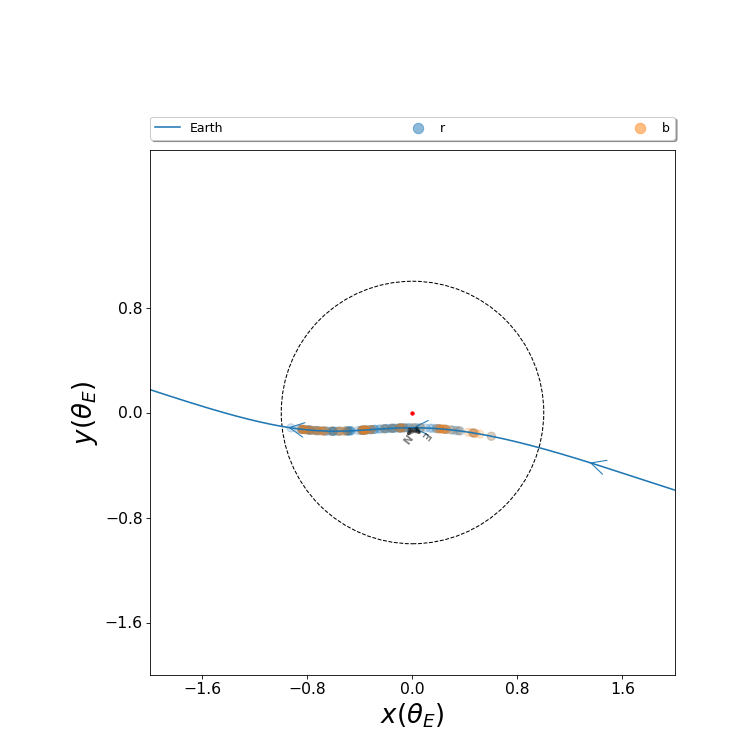

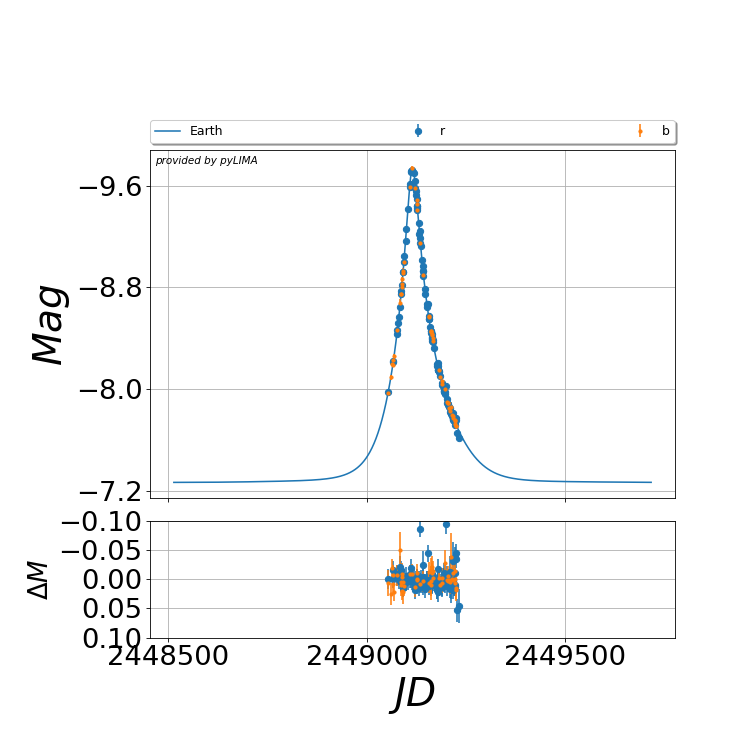

In [9]:
%matplotlib widget
pyLIMA_plots.plot_lightcurves(fspl, fit_1.fit_results['best_model'])
pyLIMA_plots.plot_geometry(fspl, fit_1.fit_results['best_model'])
plt.show()

In [10]:
# Veamos los parametros ajustados
print(fit_1.fit_results['best_model'])

#Podemos ver la matriz de covarianza
print(fit_1.fit_results['covariance_matrix'])

#La raiz cuadrada de los elemntos de la diagonal nos dicen las incertezas del ajuste
print(np.sqrt(np.diag(fit_1.fit_results['covariance_matrix'])))

[2449115.7229312235, 0.11616792513666149, 120.40474922253419, 0.031485452352034024, -0.14203061641259898, 0.18551718230409503, 82723982037884.88, -9335681075187.043, 32745110690994.445, -3363067751989.042]
[[ 7.86581369e-03  4.97646866e-04  1.19691866e-02  6.95402867e-03
  -3.68521458e-04 -5.45645791e-04  1.66397326e-14  1.09652154e-14
   2.42278671e-14  1.54360200e-14]
 [ 4.97646866e-04  6.60021864e-04  3.25845281e-04  9.40342656e-03
   3.72627897e-04 -8.25070344e-06  1.93351860e-15  8.86369243e-16
  -2.68172621e-15 -6.18666203e-17]
 [ 1.19691866e-02  3.25845280e-04  2.23171439e-01  4.38377567e-03
  -1.06990840e-02 -3.75366301e-03  2.89406920e-13  1.95973187e-13
   4.95523788e-13  2.91262740e-13]
 [ 6.95402867e-03  9.40342656e-03  4.38377567e-03  1.34016833e-01
   5.27726910e-03 -1.12894981e-04  2.72192814e-14  1.24049179e-14
  -3.87979138e-14 -1.22236595e-15]
 [-3.68521458e-04  3.72627897e-04 -1.06990840e-02  5.27726910e-03
   9.87603933e-04  2.02026695e-04 -1.29935095e-14 -9.0503598

In [11]:
# OGLE

In [12]:
# OGLE

In [13]:
# KMTC19_I

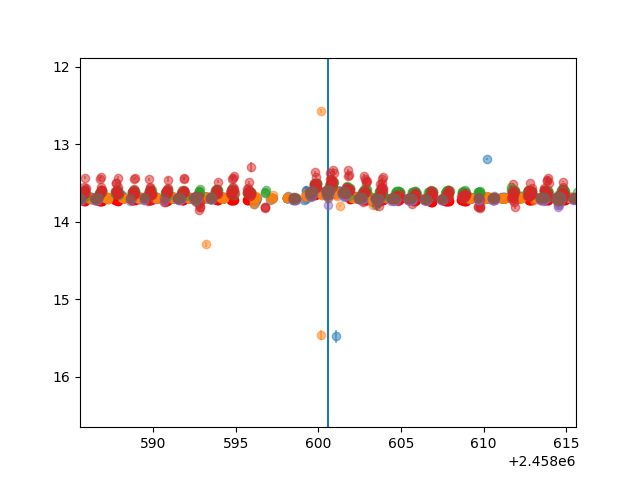

In [14]:
cols = ['HJD', 'Delta_flux', 'flux_err', 'fwhm', 'sky', 'secz']
cols2 = [ "HJD",  "Delta_flux", "flux_err",  "mag" , "mag_err",  "fwhm"  ,"sky",  "secz"]

OGLE = pd.read_csv("/home/anibal/Downloads/BLG551/phot.dat",sep="\s+", names=["time","mag","errmag","seeing","sky"])
KMTA03_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTA03_I.pysis",sep='\s+', names=cols2,skiprows=1)
KMTA43_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTA43_I.pysis",sep='\s+', names=cols2,skiprows=1)
KMTC43_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTC43_I.pysis",sep='\s+', names=cols2,skiprows=1)
KMTC03_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTC03_I.pysis",sep='\s+', names=cols2,skiprows=1)
KMTS03_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTS03_I.pysis",sep='\s+', names=cols2,skiprows=1)
KMTS43_I = pd.read_csv("/home/anibal/Downloads/BLG551/KMTS43_I.pysis",sep='\s+', names=cols2,skiprows=1)

plt.close("all")
plt.errorbar(OGLE["time"],OGLE["mag"],OGLE["errmag"],marker="o",ls="",color="r")
plt.errorbar(KMTA03_I["HJD"]+2450000,KMTA03_I["mag"],KMTA03_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.errorbar(KMTA43_I["HJD"]+2450000,KMTA43_I["mag"],KMTA43_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.errorbar(KMTC43_I["HJD"]+2450000,KMTC43_I["mag"],KMTC43_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.errorbar(KMTC03_I["HJD"]+2450000,KMTC03_I["mag"],KMTC03_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.errorbar(KMTS03_I["HJD"]+2450000,KMTS03_I["mag"],KMTS03_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.errorbar(KMTS43_I["HJD"]+2450000,KMTS43_I["mag"],KMTS43_I["mag_err"],marker="o",ls="",alpha=0.5)
plt.axvline( 8600.584 +2450000)
plt.xlim(8600.584 +2450000-15,8600.584 +2450000+15)
plt.gca().invert_yaxis()
plt.show()

In [15]:
RA="17:42:17.35"
Dec="-24:04:01.99"

In [16]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Given RA and Dec
ra_hms = "17:42:17.35"
dec_dms = "-24:04:01.99"

# Convert to degrees
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=(u.hourangle, u.deg))
ra_deg = coord.ra.deg
dec_deg = coord.dec.deg

print(f"RA in degrees: {ra_deg}, Dec in degrees: {dec_deg}")


RA in degrees: 265.5722916666666, Dec in degrees: -24.067219444444444


In [17]:
8600.584 +2450000

2458600.584

In [18]:

your_event = event.Event(ra=ra_dec[0], dec=ra_dec[1])
your_event.name = 'BLG551'

telescope_1 = telescopes.Telescope(name = 'OGLE', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((OGLE["time"],OGLE["mag"],OGLE["errmag"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

telescope_2 = telescopes.Telescope(name = 'KMTA03_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTA03_I["HJD"]+2450000,KMTA03_I["mag"],KMTA03_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])


telescope_3 = telescopes.Telescope(name = 'KMTA43_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTA43_I["HJD"]+2450000,KMTA43_I["mag"],KMTA43_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

telescope_4 = telescopes.Telescope(name = 'KMTC43_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTC43_I["HJD"]+2450000,KMTC43_I["mag"],KMTC43_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])
telescope_5 = telescopes.Telescope(name = 'KMTC03_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTC03_I["HJD"]+2450000,KMTC03_I["mag"],KMTC03_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])
telescope_6 = telescopes.Telescope(name = 'KMTS43_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTS43_I["HJD"]+2450000,KMTS43_I["mag"],KMTS43_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])
telescope_7 = telescopes.Telescope(name = 'KMTS03_I', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((KMTS03_I["HJD"]+2450000,KMTS03_I["mag"],KMTS03_I["mag_err"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])



your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)
your_event.telescopes.append(telescope_3)
your_event.telescopes.append(telescope_4)
your_event.telescopes.append(telescope_5)
your_event.telescopes.append(telescope_6)
your_event.telescopes.append(telescope_7)


# your_event.telescopes[0].ld_gamma = 0.5
# your_event.telescopes[1].ld_gamma = 0.5
# your_event.telescopes[2].ld_gamma = 0.5
# your_event.telescopes[3].ld_gamma = 0.5
# your_event.telescopes[4].ld_gamma = 0.5
# your_event.telescopes[5].ld_gamma = 0.5
# your_event.telescopes[6].ld_gamma = 0.5
your_event.check_event()

#aca le indicamos que en el ajuste considere solo el parallax
pspl = PSPL_model.PSPLmodel(your_event)
# Podemos considerar tambien un modelo de fuente finita
# fspl = FSPLarge_model.FSPLargemodel(your_event)
fit_1 = TRF_fit.TRFfit(pspl)
fit_1.model_parameters_guess = [2458600.584, 1, 0.5]
fit_1.fit_parameters['t0'][1] = [2458600.584 - 10, 2458600.584 + 10]  # t0 limits
fit_1.fit_parameters['u0'][1] = [1 - 0.5, 1 + 0.5]  # u0 limits
fit_1.fit_parameters['tE'][1] = [0.1, 1]  # tE
# fit_1.fit_parameters['rho'][1] = [0.5,6]  # tE
fit_1.fit()

check_event  : Everything looks fine...
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2458600.584, 1.0, 0.5, 108350.85428676703, 187464.20676375236, 129821.620010349, 174052.20502376498, 115036.16387334236, 188581.5895662818, 164241.6719329048, 161251.8930790921, 256970.146809301, 42110.68601716415, 126285.53210247778, 176826.87884524174, 120572.62746660842, 177535.3805599719]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2458600.768089413, 1.499999999995475, 0.6513556217533029, 232707.6229598262, 63089.530696473616, 218947.53212599226, 84842.0012388457, 180336.96928428556, 123212.04277025079, 354718.2186632793, -29245.615088286333, 624732.8365717173, -325698.0020686123, 253192.5012601836, 49852.07430063132, 245552.17714639788, 52502.59237454876] chi2 660362.7379761244


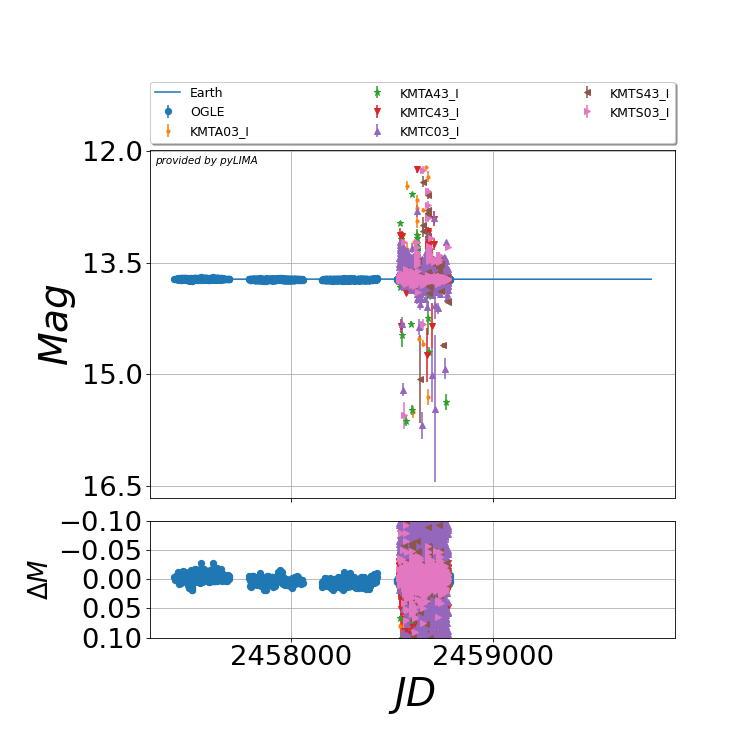

In [19]:
%matplotlib widget
pyLIMA_plots.plot_lightcurves(pspl, fit_1.fit_results['best_model'])
# pyLIMA_plots.plot_geometry(fspl, fit_1.fit_results['best_model'])
plt.show()

<ErrorbarContainer object of 3 artists>

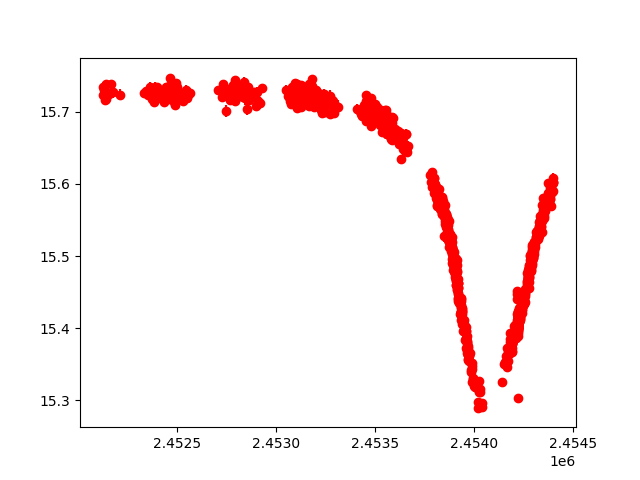

In [20]:
cols2 = [ "HJD",  "Delta_flux", "flux_err",  "mag" , "mag_err",  "fwhm"  ,"sky",  "secz"]

OGLE = pd.read_csv("/home/anibal/Downloads/par02/phot.dat",sep="\s+", names=["time","mag","errmag","seeing","sky"])

plt.close("all")
plt.errorbar(OGLE["time"],OGLE["mag"],OGLE["errmag"],marker="o",ls="",color="r")


In [21]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Given RA and Dec
ra_hms = "17:57:23.19"
dec_dms = "-28:46:32.1"

# Convert to degrees
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=(u.hourangle, u.deg))
ra_deg = coord.ra.deg
dec_deg = coord.dec.deg

print(f"RA in degrees: {ra_deg}, Dec in degrees: {dec_deg}")


your_event = event.Event(ra=ra_dec[0], dec=ra_dec[1])
your_event.name = 'par02'

telescope_1 = telescopes.Telescope(name = 'OGLE', 
                                   camera_filter = 'I',
                                   light_curve = np.column_stack((OGLE["time"],OGLE["mag"],OGLE["errmag"])),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

your_event.telescopes.append(telescope_1)
your_event.check_event()

#aca le indicamos que en el ajuste considere solo el parallax
pspl = PSPL_model.PSPLmodel(your_event, parallax=["Full", 2454087.1825415874])
# Podemos considerar tambien un modelo de fuente finita
# fspl = FSPLarge_model.FSPLargemodel(your_event)
fit_1 = TRF_fit.TRFfit(pspl)
# fit_1.model_parameters_guess = [2458600.584, 1, 0.5]
# fit_1.fit_parameters['t0'][1] = [2458600.584 - 10, 2458600.584 + 10]  # t0 limits
# fit_1.fit_parameters['u0'][1] = [1 - 0.5, 1 + 0.5]  # u0 limits
# fit_1.fit_parameters['tE'][1] = [0.1, 1]  # tE
# fit_1.fit_parameters['rho'][1] = [0.5,6]  # tE
fit_1.fit()

RA in degrees: 269.34662499999996, Dec in degrees: -28.775583333333334
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope OGLE: SUCCESS
Selecting OGLE to estimate u0, tE and fs
initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2454038.51955, 0.8414699828017812, 257.6281758498084, 0.0, 0.0, 41267.82259525595, 5568.258130629289]
fit  : Trust Region Reflective fit SUCCESS
best_model: [2454027.236893127, 0.7361429437102244, 371.53472915097996, 0.04641874710728183, -0.05319011466917469, 36511.25921284586, 10095.928968098828] chi2 3527.638758270812


Parallax(Full) estimated for the telescope OGLE: SUCCESS


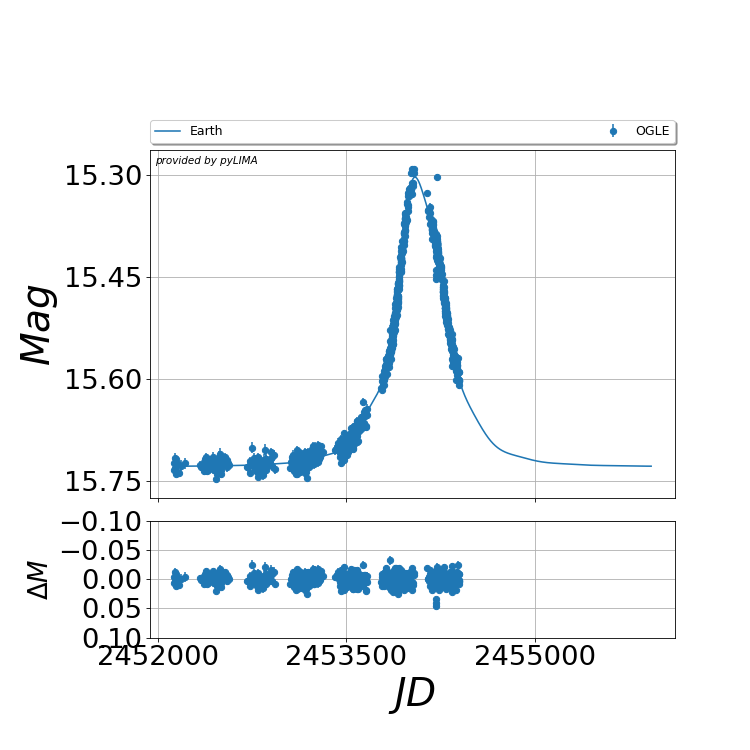

In [22]:
%matplotlib widget
pyLIMA_plots.plot_lightcurves(pspl, fit_1.fit_results['best_model'])
# pyLIMA_plots.plot_geometry(fspl, fit_1.fit_results['best_model'])
plt.show()